In [21]:
import numpy as np
import matplotlib.pyplot as plt
from rlxutils import subplots
import pandas as pd
import sys
sys.path.append("..")
from lib import data
from lib import sar
from lib import io
from lib import trainer
from sklearn.ensemble import RandomForestRegressor
from progressbar import progressbar as pbar

## load train and test images

In [2]:
base_path = "/home/rlx/data/sar-recovery"
date_train = '20100520'
date_test  = '20120720'

window_size = 7

In [3]:
smtr = io.load_bcn_scatter_matrix(base_path, date_train)
smts = io.load_bcn_scatter_matrix(base_path, date_test)

In [4]:
wsmtr = sar.avgpool2D_complex(smtr, window_size = window_size)
wsmts = sar.avgpool2D_complex(smts, window_size = window_size)

In [5]:
ncmtr = sar.compute_quadpol_normalized_coherence_matrix(smtr, window_size=window_size)
ncmts = sar.compute_quadpol_normalized_coherence_matrix(smts, window_size=window_size)


In [6]:
wsmtr.shape, ncmtr.shape

((628, 228, 2, 2), (628, 228, 9))

## define train/test/val split mask

may use spatial split to attempt to avoid spatial leakage between train, test, val

In [9]:
h, w, _, _ = wsmtr.shape

splitmask_random = data.cv_splitpixels_random(h, w, train_pct = .70, test_pct = .15, val_pct = .15)
splitmask_bands  = data.cv_splitpixels_spatial(h, w, pixels_train = 70, pixels_test = 15, pixels_val = 15, angle = np.pi/4)

TRAIN, TEST, VAL = 0,1,2

In [10]:
wsmtr_VV_ampl = (wsmtr[:,:,1,1]*wsmtr[:,:,1,1].conjugate()).real
wsmts_VV_ampl = (wsmts[:,:,1,1]*wsmts[:,:,1,1].conjugate()).real

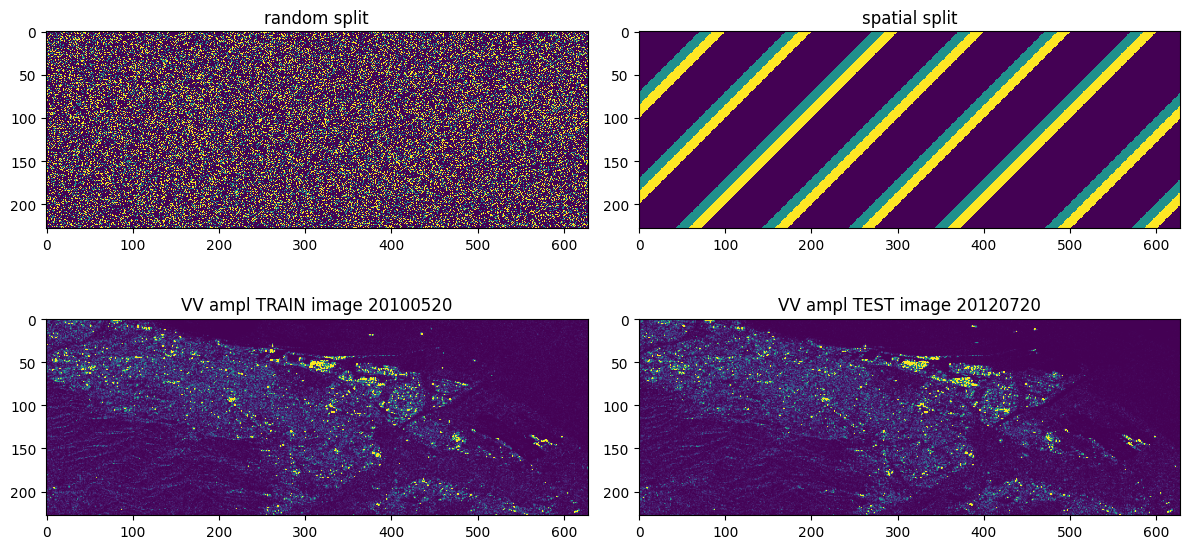

In [11]:
a,b = np.percentile(list(wsmtr_VV_ampl.flatten()) + list(wsmts_VV_ampl.flatten()), [1,99])

for ax, i in subplots(4, usizex=6, n_cols=2):
    if i==0: plt.imshow(splitmask_random.T, interpolation='none'); plt.title("random split")
    if i==1: plt.imshow(splitmask_bands.T, interpolation='none'); plt.title("spatial split")
    if i==2: plt.imshow(wsmtr_VV_ampl.T, vmin=a, vmax=b); plt.title(f"VV ampl TRAIN image {date_train}") 
    if i==3: plt.imshow(wsmts_VV_ampl.T, vmin=a, vmax=b); plt.title(f"VV ampl TEST image {date_test}") 

## train random forest

**input**: $\langle S_{vv}\rangle$ and $\langle S_{vh} \rangle$ from scatter matrix, real and imag (4 values) 

**output**: $\delta_1 = \langle S_{hh} \rangle^2 / P$ , real part (imag is zero)

### build train and test data

In [15]:
splitmask = splitmask_bands
t = trainer.Trainer(wsmtr, wsmts, ncmtr, ncmts, splitmask, ['VV', 'VH'], 'd1').split()
t.xtr.shape, t.xts.shape, t.ytr.shape, t.yts.shape

((102144, 4), (20520, 4), (102144,), (20520,))

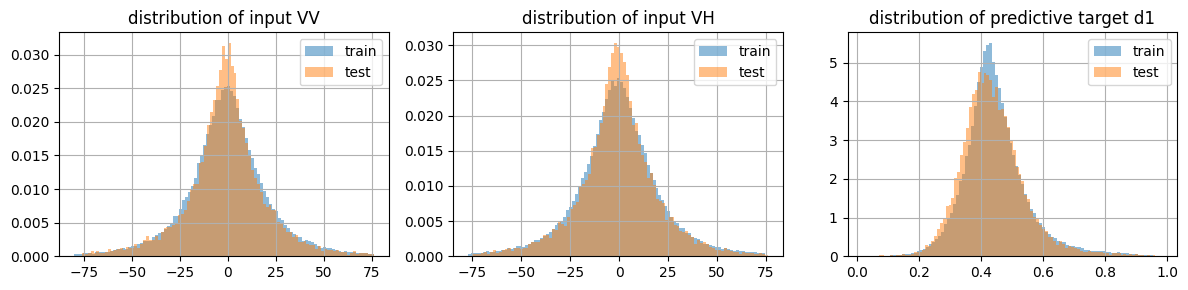

In [16]:
t.plot_distributions()

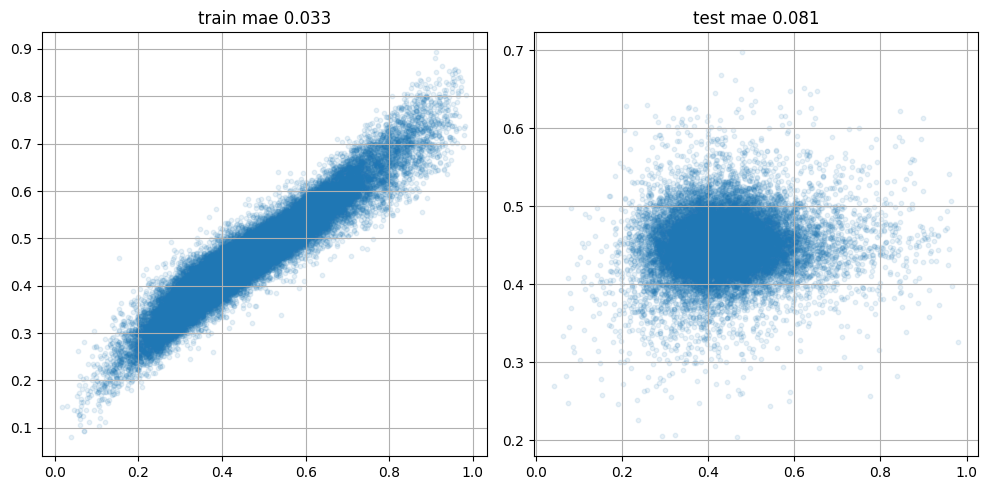

In [17]:
t.set_estimator(RandomForestRegressor(max_depth=50, n_estimators=20, n_jobs=6))
t.fit()
t.plot_predictions()

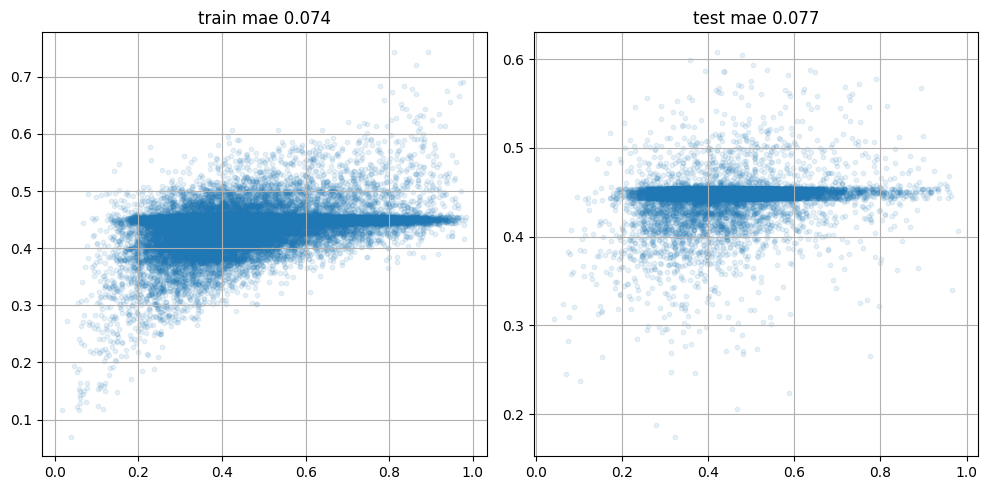

In [18]:
t.set_estimator(RandomForestRegressor(max_depth=10, n_estimators=20, n_jobs=6))
t.fit()
t.plot_predictions()

## increasing RF complexity

In [24]:
depths = list(range(1,100,5))
errs = []
for depth in pbar(depths):
    t.set_estimator(RandomForestRegressor(max_depth=depth, n_estimators=20, n_jobs=6))
    t.fit()
    errs.append([t.errtr, t.errts])
errs = np.r_[errs]
errs_tr = errs[:,0]
errs_ts = errs[:,1]


100% (20 of 20) |########################| Elapsed Time: 0:01:05 Time:  0:01:05


Text(0, 0.5, 'mean absolute error')

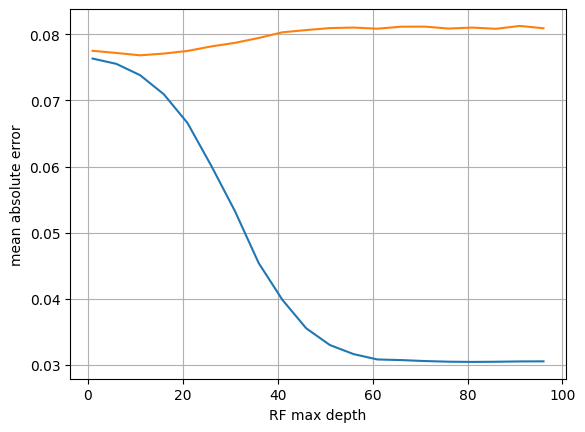

In [32]:
plt.plot(depths, errs_tr, label='train')
plt.plot(depths, errs_ts, label='test')
plt.grid();
plt.xlabel("RF max depth")
plt.ylabel("mean absolute error")

## train random forest sanity check

**input**: $\langle S_{vv}\rangle$ and $\langle S_{hh} \rangle$ from scatter matrix, real and imag (4 values) 

**output**: $\delta_1 = \langle S_{hh} \rangle^2 / P$ , real part (imag is zero)

In [33]:
splitmask = splitmask_bands
t = trainer.Trainer(wsmtr, wsmts, ncmtr, ncmts, splitmask, ['HH', 'VV'], 'd1').split()


In [34]:
depths = list(range(1,100,5))
errs = []
for depth in pbar(depths):
    t.set_estimator(RandomForestRegressor(max_depth=depth, n_estimators=20, n_jobs=6))
    t.fit()
    errs.append([t.errtr, t.errts])
errs = np.r_[errs]
errs_tr = errs[:,0]
errs_ts = errs[:,1]


100% (20 of 20) |########################| Elapsed Time: 0:00:57 Time:  0:00:57


Text(0, 0.5, 'mean absolute error')

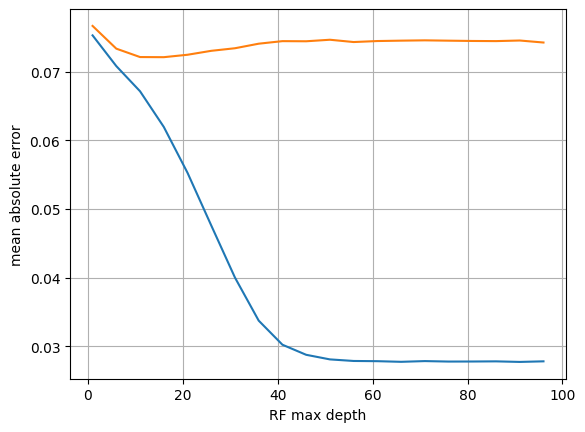

In [35]:
plt.plot(depths, errs_tr, label='train')
plt.plot(depths, errs_ts, label='test')
plt.grid();
plt.xlabel("RF max depth")
plt.ylabel("mean absolute error")